In [2]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from AnalyticCoolingCurves import *
from unpackConfigurations import unpackConfiguration
from unpackConfigurationsMK import unpackConfigurationMK
import ThermalFrontFormulation as TF
import os
import pickle as pkl
from LRBv2 import LRBv2
from LRBv21 import LRBv21
import matplotlib as mpl
import copy
from LengyelReinkeFormulation import *
import ThermalFrontFormulation as TF
import colorcet as cc
from scipy import interpolate
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, MultipleLocator, FormatStrFormatter, AutoMinorLocator

from DLScommonTools import *

%load_ext autoreload
%autoreload 2

set_matplotlib_defaults()

# Objective

- See what happens to window size as we decrease SOL length/make wall closer
- For the inner, this reduces flux compression which is beneficial
- But also it reduces connection length which is not good
- There may be an optimum somewhere along the length

# IO

In [3]:
sepadd = 2
data = dict()

file_paths = {
    "V10" : r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc",
     "V10X" : r"C:\Users\Mike\OneDrive\Project\DLS\from_sarah\V10Xgluedgrid_balance\balance.nc",
     "SPR38" : r"C:\Users\Mike\OneDrive\Project\DLS\STEP_SPR038\drsep0mm\balance_SPR038.nc",
     "SPR38L" : r"C:\Users\Mike\OneDrive\Project\DLS\SPR38-longInner\balance.nc"}

designs = file_paths.keys()
eqb = dict()
for side in ["iu", "ou"]:
    eqb[side] = dict()
    
    for design in designs:
        eqb[side][design] = unpackConfigurationMK(File = file_paths[design], Type = side, sepadd=2, resolution = 5000)

print("Complete")

Complete


In [3]:
sepadd = 2
data = dict()

file_paths = {
    "V10" : r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc",
     "V10X" : r"C:\Users\Mike\OneDrive\Project\DLS\from_sarah\V10Xgluedgrid_balance\balance.nc",
     "SPR38" : r"C:\Users\Mike\OneDrive\Project\DLS\STEP_SPR038\drsep0mm\balance_SPR038.nc",
     "SPR38L" : r"C:\Users\Mike\OneDrive\Project\DLS\SPR38-longInner\balance.nc"}

designs = file_paths.keys()
eqb100k = dict()
for side in ["iu", "ou"]:
    eqb100k[side] = dict()
    
    for design in designs:
        eqb100k[side][design] = unpackConfigurationMK(File = file_paths[design], Type = side, sepadd=2, resolution = 100000)

print("Complete")

Complete


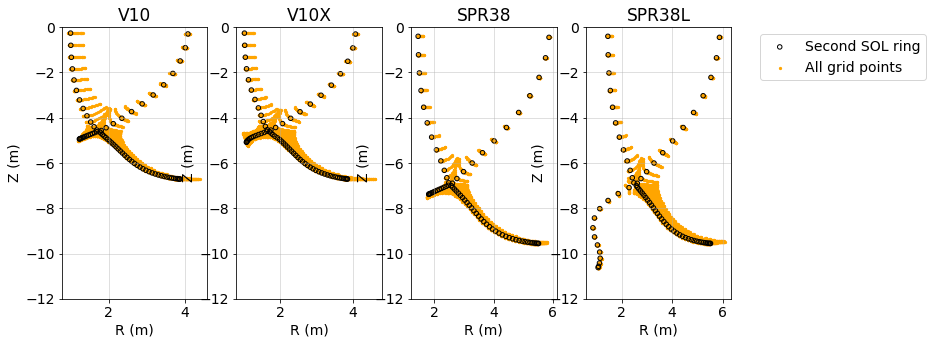

In [3]:
fig, axes = plt.subplots(1,4, figsize=(12,5))

for i, design in enumerate(designs):
    data = eqb["ou"][design]

    axes[i].scatter(data["R_ring"], data["Z_ring"], zorder = 1, color = "black", s = 20, facecolor="None", label = "Second SOL ring")
    axes[i].scatter(data["R_full"], data["Z_full"], alpha = 1, zorder = 0, color = "orange", s = 5, label = "All grid points")
    axes[i].set_ylim(-12, 0)
    axes[i].set_title(design, fontsize = 17)
    axes[i].grid(alpha=0.5)
    axes[i].set_xlabel("R (m)")
    axes[i].set_ylabel("Z (m)")
    
axes[-1].legend(bbox_to_anchor=(1.15,1))

# SPR38 Long
- Made by Ryoko to extend inner length

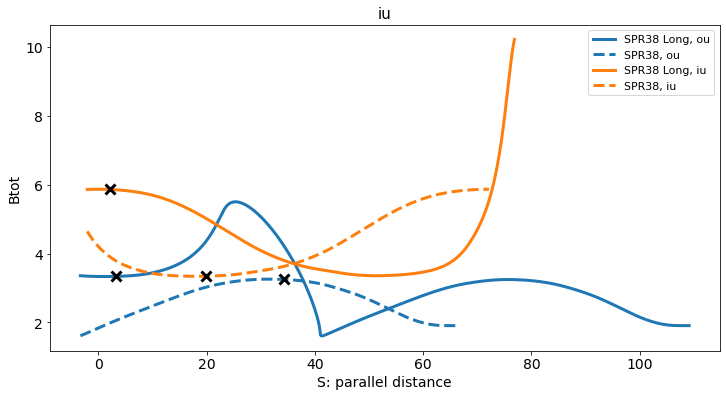

In [4]:
fig, ax = plt.subplots(figsize=(12,6))

colors = [plt.get_cmap("tab10")(x) for x in range(2)]

for i, side in enumerate(["ou", "iu"]):
    
    d = eqb[side]["SPR38L"]
    Sx = d["S"][d["Xpoint"]]
    ax.plot(d["S"]-Sx, d["Btot"], linewidth = 3, label = "SPR38 Long, {}".format(side), zorder = 5, color = colors[i])
    ax.scatter(d["S"][d["Xpoint"]], d["Btot"][d["Xpoint"]], color = "black", marker = "x", s = 100, zorder = 10)
    
    d = eqb[side]["SPR38"]
    ax.plot(d["S"]-Sx, d["Btot"], linewidth = 3, linestyle = "dashed", label = "SPR38, {}".format(side), zorder = 5, color = colors[i])
    ax.scatter(d["S"][d["Xpoint"]], d["Btot"][d["Xpoint"]], color = "black", marker = "x", s = 100, zorder = 10)

    ylims = ax.axes.get_ylim()
    # ax.vlines(0, ylims[0], ylims[1], color = "black", linestyle = "dashed", label = "Target", linewidth = 3)
    # ax.vlines(d["S"][d["Xpoint"]], ylims[0], ylims[1], color = "black", linestyle = "dotted",linewidth =3,  label = "X-point")

    ax.set_title(side, fontsize = 15)
    ax.legend(fontsize = 11)
    ax.set_xlabel("S: parallel distance"); 
    ax.set_ylabel("Btot")
ax.grid(which="both")


- Looks like my balance unpacker doesn't work for the new SPR38 long grid
- Likely because the profile is very different
- Proceed with SPR38

# Scaling wall length

Text(0, 0.5, '$B_{tot}$ (T)')

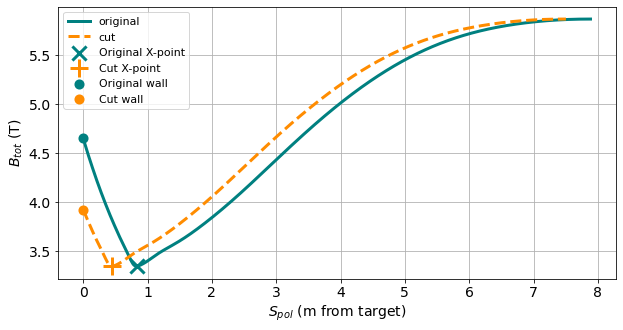

In [4]:
side = "iu"
design = "SPR38"

colors = mike_cmap(2)

d_original= eqb[side][design]
d = copy.deepcopy(d_original)

Xpoint = d["Xpoint"]
Sx = d["S"][Xpoint]
Bx = d["Btot"][Xpoint]

len_fac = 0.8

# find index to cut up to
target_length = Sx * (1-len_fac)
cut_idx = np.argmin(np.abs(d["S"] - target_length))

for param in ["S", "Spol", "Btot", "Bpol"]:
    d[param] = d[param][cut_idx:]
    
for param in ["S", "Spol"]:
    d[param] -= d[param][0]

d["Xpoint"] = d["Xpoint"] - cut_idx

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(d_original["Spol"], d_original["Btot"], linewidth = 3, label = "original", color = colors[0])
ax.plot(d["Spol"], d["Btot"], linewidth = 3, label = "cut", linestyle = "dashed", color = colors[1])

ax.scatter(d_original["Spol"][d_original["Xpoint"]], d_original["Btot"][d_original["Xpoint"]], color = colors[0], marker = "x", s= 200,linewidth =3,  label = "Original X-point", zorder = 10)
ax.scatter(d["Spol"][d["Xpoint"]], d["Btot"][d["Xpoint"]], color = colors[1], marker = "+", s= 300,linewidth =3,  label = "Cut X-point", zorder = 10)

ax.scatter(d_original["Spol"][0], d_original["Btot"][0], color = colors[0], marker = "o", s= 50,linewidth =3, zorder = 10, label = "Original wall")
ax.scatter(d["Spol"][0], d["Btot"][0], color = colors[1], marker = "o", s= 50,linewidth =3, zorder = 10, label = "Cut wall")

# ax.set_title(side, fontsize = 15)
ax.legend(fontsize = 11)
ax.set_xlabel("$S_{pol}$ (m from target)"); 
ax.set_ylabel("$B_{tot}$ (T)")
# ax.grid(which="both")


In [5]:
side = "iu"
design = "SPR38"

def cut_wall(d_input, reduction_fac):

    d = copy.deepcopy(d_input)

    Xpoint = d["Xpoint"]
    Spolx = d["Spol"][Xpoint]
    Bx = d["Btot"][Xpoint]

    # find index to cut up to
    target_length = Spolx * reduction_fac
    cut_idx = np.argmin(np.abs(d["Spol"] - target_length))

    for param in ["S", "Spol", "Btot", "Bpol", "R", "Z"]:
        d[param] = d[param][cut_idx:]
        
    for param in ["S", "Spol"]:
        d[param] -= d[param][0]

    d["Xpoint"] = d["Xpoint"] - cut_idx
    
    return d

In [6]:
list_cuts = np.round(np.arange(0, 0.9, 0.1), 2)
# list_cuts = [0.1, 0.5, 0.9, 1.0]

data_cuts = dict()
design = "SPR38"
stats = dict()

for side in ["iu", "ou"]:
    data_cuts[side] = dict()
    stats[side] = defaultdict(list)
    
    for cut in list_cuts:
        data_cuts[side][cut] = cut_wall(eqb[side][design], cut)
        d = data_cuts[side][cut]
        
        stats[side]["Xpoint"].append(d["Xpoint"])
        stats[side]["Lx"].append(d["S"][d["Xpoint"]])
        stats[side]["Lpolx"].append(d["Spol"][d["Xpoint"]])
        stats[side]["Bx"].append(d["Btot"][d["Xpoint"]])
        stats[side]["Bt"].append(d["Btot"][0])
        stats[side]["BxBt"].append(d["Btot"][d["Xpoint"]] / d["Btot"][0])
        stats[side]["polreduction"].append(cut) # reduction factor
        
    stats[side]["reduction"] = np.round(1 - stats["iu"]["Lx"] / stats["iu"]["Lx"][0], 2)

print("Cuts prepared: ",list_cuts)

Cuts prepared:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]


In [19]:
stats[side]["reduction"]

array([0.  , 0.03, 0.08, 0.12, 0.17, 0.23, 0.3 , 0.37, 0.49])

## Plot impact on Bx/Bt and Lc

Text(0.5, 1.0, 'Outer divertor')

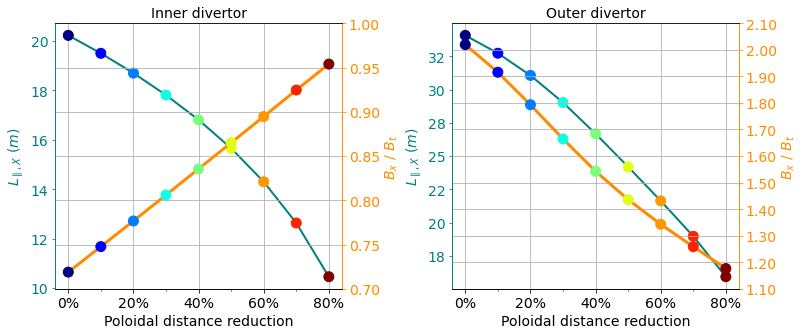

In [25]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
fig.tight_layout(pad=5)
side = "iu"
colors = mike_cmap(2)
colorsr = make_colors(len(list_cuts), plt.get_cmap("jet"))

for i, side in enumerate(["iu", "ou"]):
    ax = axes[i]
    ax.plot(stats[side]["polreduction"], stats[side]["Lx"], color = colors[0], linewidth = 2)
    ax.scatter(stats[side]["polreduction"], stats[side]["Lx"], marker = "o", color = colorsr, zorder = 50, s = 100)
    ax.grid()
    ax.grid(axis="x")
    ax2 = ax.twinx()
    ax2.plot(stats[side]["polreduction"], stats[side]["BxBt"], marker = "v", color = colors[1])
    ax2.scatter(stats[side]["polreduction"], stats[side]["BxBt"], marker = "o", color = colorsr, zorder = 50, s = 100)
    ax2.yaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
    ax2.set_ylabel("$B_{x}\ /\ B_{t}$")
    
    ax.yaxis.label.set_color(colors[0])
    ax.tick_params(axis='y', colors=colors[0])
    ax.spines['left'].set_color(colors[0])
    ax2.spines["left"].set_color(colors[0])
    
    ax2.yaxis.label.set_color(colors[1])
    ax2.tick_params(axis='y', colors=colors[1])
    ax2.spines['right'].set_color(colors[1])
    ax.spines["right"].set_color(colors[1])

    
    if side == "iu":
        ax2.yaxis.set_major_locator(MultipleLocator(0.05))
        ax2.set_ylim(0.7, 1.0)
    elif side == "ou":
        ax2.yaxis.set_major_locator(MultipleLocator(0.1))
        ax2.set_ylim(1.1, 2.1)
# axes[0].grid()
# axes[0].grid(axis="x")

for ax in axes:
    # ax.grid(color = "black", alpha = 0.3)
    

    ax.set_xlabel("Poloidal distance reduction")
    ax.set_ylabel("$L_{\parallel,X}\ (m)$")
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    
    # ax.set_xlim(0,1)
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))

axes[0].set_title("Inner divertor")
axes[1].set_title("Outer divertor")


## Plot in RZ space

(1.5, 3.5)

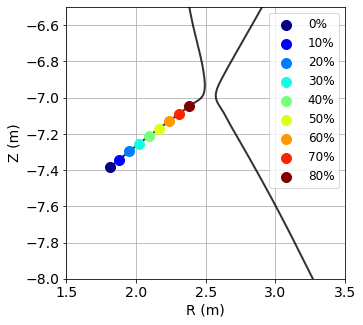

In [38]:
fig, ax = plt.subplots(figsize = (5,5))
colors = make_colors(len(list_cuts), plt.get_cmap("jet"))

ax.set_xlabel("R (m)")
ax.set_ylabel("Z (m)")

design = "SPR38"

ax.plot(eqb["iu"][design]["R"], -eqb["iu"][design]["Z"], 
           color = "black",  alpha = 0.8, linewidth = 2)
ax.plot(eqb["ou"][design]["R"], -eqb["ou"][design]["Z"], 
           color = "black",  alpha = 0.8, linewidth = 2)

side = "iu"
for i, cut in enumerate(list_cuts):
    ax.scatter(data_cuts[side][cut]["R"][0], -data_cuts[side][cut]["Z"][0], color = colors[i], zorder = 10, s = 100,
              label = "{:.0%}".format(stats["iu"]["polreduction"][i]))

ax.legend(fontsize=12)
ax.set_ylim(-8,-6.5)
ax.set_xlim(1.5,3.5)

In [19]:
stats["iu"]["reduction"]

array([0.  , 0.04, 0.08, 0.12, 0.17, 0.23, 0.29, 0.37, 0.48])

# Run cases

In [49]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # in development
    "upstreamGrid": True, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, #upstream density
    "nu0" : 1e20,
    "cz0" : 0.02,
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncKallenbachAr, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
}


## Density

In [43]:
cut_study = dict()

for side in ["iu"]:
    cut_study[side] = dict()
    print("Solving side", side)
    
    for cut in data_cuts[side].keys():
        print("Solving reduction", cut)
        out = []
        results = dict()

        for param in ["window", "threshold", "window_ratio"]:
            results[param] = []


        d = copy.deepcopy(data_cuts[side][cut])
        i = 0

        constants = constants_default.copy()
        radios = radios_default.copy()

        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]
        
        radios["upstreamGrid"] = True
        constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        constants["Lfunc"] = LfuncKallenbachAr
        constants["cz0"] = 0.05
        
        out.append(LRBv21(constants,radios,d["S"],indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 1, verbosity = 0,
                                            control_variable = "density"))

        out[i]["SpolPlot"] = [d["Spol"][x] for x in indexRange]

        results["window"].append(out[i]["cvar"][-1] - out[i]["cvar"][0])
        results["window_ratio"].append(out[i]["cvar"][-1] / out[i]["cvar"][0])
        results["threshold"].append(out[i]["cvar"][0])
        results["indexRange"] = indexRange
        results["constants"] = constants
        results["radios"] = radios
        results["out"] = out

        # Take out any thresholds for a window ratio < 1
        for i, x in enumerate(results["threshold"]):
            if results["window_ratio"][i] < 1:
                results["threshold"][i] = np.nan
        try:
            results["rel_threshold"] = results["threshold"] / max([x for x in results["threshold"] if ~np.isnan(x)])
        except:
            pass
        
        cut_study[side][cut] = results.copy()

Solving side iu
Solving reduction 0.0
Solving...0...19...35...49...60...70...77...84...89...92...95...98...100...102...104...Complete in 21.7 seconds
Solving reduction 0.1
Solving...0...17...31...44...54...62...69...75...80...83...86...88...90...92...94...Complete in 20.7 seconds
Solving reduction 0.2
Solving...0...15...27...38...47...54...61...66...70...72...75...77...79...81...83...Complete in 20.9 seconds
Solving reduction 0.3
Solving...0...13...23...33...40...47...53...57...60...63...65...67...69...71...73...Complete in 22.0 seconds
Solving reduction 0.4
Solving...0...10...19...27...34...39...44...48...50...53...55...57...59...60...62...Complete in 19.9 seconds
Solving reduction 0.5
Solving...0...8...16...22...28...32...36...39...41...44...45...47...49...50...52...Complete in 21.2 seconds
Solving reduction 0.6
Solving...0...6...12...17...21...25...27...30...32...33...35...37...38...40...41...Complete in 22.2 seconds
Solving reduction 0.7
Solving...0...5...9...12...15...18...20...21

## Power

In [188]:
cut_study_power = dict()

for side in ["iu"]:
    cut_study_power[side] = dict()
    print("Solving side", side)
    
    for cut in data_cuts[side].keys():
        print("Solving reduction", cut)
        out = []
        results = dict()

        for param in ["window", "threshold", "window_ratio"]:
            results[param] = []


        d = copy.deepcopy(data_cuts[side][cut])
        i = 0

        constants = constants_default.copy()
        radios = radios_default.copy()

        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]
        
        radios["upstreamGrid"] = True
        constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        constants["Lfunc"] = LfuncKallenbachAr
        constants["cz0"] = 0.05
        
        out.append(LRBv21(constants,radios,d["S"],d["Spol"],indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 1, verbosity = 0,
                                            control_variable = "power"))

        out[i]["SpolPlot"] = [d["Spol"][x] for x in indexRange]

        results["window"].append(out[i]["cvar"][-1] - out[i]["cvar"][0])
        results["window_ratio"].append(out[i]["cvar"][-1] / out[i]["cvar"][0])
        results["threshold"].append(out[i]["cvar"][0])
        results["indexRange"] = indexRange
        results["constants"] = constants
        results["radios"] = radios
        results["out"] = out

        # Take out any thresholds for a window ratio < 1
        for i, x in enumerate(results["threshold"]):
            if results["window_ratio"][i] < 1:
                results["threshold"][i] = np.nan
        try:
            results["rel_threshold"] = results["threshold"] / max([x for x in results["threshold"] if ~np.isnan(x)])
        except:
            pass
        
        cut_study_power[side][cut] = results.copy()

Solving side iu
Solving reduction 0.0
Solving...0...19...35...49...60...70...

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:62: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))


77...84...89...92...95...98...100...102...104...Complete in 29.0 seconds
Solving reduction 0.1
Solving...0...17...31...44...54...62...69...75...80...83...86...88...90...92...94...Complete in 23.3 seconds
Solving reduction 0.2
Solving...0...15...27...38...47...54...61...66...70...72...75...77...79...81...83...Complete in 23.7 seconds
Solving reduction 0.3
Solving...0...13...23...33...40...47...53...57...60...63...65...67...69...71...73...Complete in 25.1 seconds
Solving reduction 0.4
Solving...0...10...19...27...34...39...44...48...50...53...55...57...59...60...62...Complete in 24.8 seconds
Solving reduction 0.5
Solving...0...8...16...22...28...32...36...39...41...44...45...47...49...50...52...Complete in 23.7 seconds
Solving reduction 0.6
Solving...0...6...12...17...21...25...27...30...32...33...35...37...38...40...41...Complete in 25.2 seconds
Solving reduction 0.7
Solving...0...5...9...12...15...18...20...21...23...24...26...27...28...30...31...Complete in 26.5 seconds
Solving reduct

# Calculate onset heights, eliminate unstable points

In [208]:
result_stats = defaultdict(list)

side = "iu"

for k, cut in enumerate(list_cuts):
    o = cut_study[side][cut]
    d = data_cuts[side][cut]
        
    crel = o["out"][0]["crel"]
    cvar = o["out"][0]["cvar"]
    splot = o["out"][0]["Splot"]
    spolplot = o["out"][0]["SpolPlot"]
    
    # Trim negative gradient
    crel_trim = crel.copy()
    cvar_trim = cvar.copy()
    
    # Find values on either side of C = 1 and interpolate onto 1 
    for i in range(len(crel)-1):
        # if crel[i] < 1 and crel[i+1] >= 1.0:
        if np.sign(crel[i]-1) != np.sign(crel[i+1]-1) and i > 0:
            print(crel[i])
            interp_par = interpolate.interp1d([crel[i], crel[i+1]], [splot[i], splot[i+1]])
            interp_pol = interpolate.interp1d([crel[i], crel[i+1]], [spolplot[i], spolplot[i+1]])
            onset_height_par = float(interp_par(1))
            onset_height_pol = float(interp_pol(1))
            break
        if i == len(crel)-2:
            onset_height_par = 0
            onset_height_pol = 0
            
    grad = np.gradient(crel)
    for i, val in enumerate(grad):
        if i > 0 and np.sign(grad[i]) != np.sign(grad[i-1]):
            crel_trim[:i] = np.nan
            cvar_trim[:i] = np.nan
            
    result_stats["windows"].append(o["window_ratio"])        
    result_stats["crel"].append(crel)
    result_stats["cvar"].append(cvar)
    result_stats["crel_trim"].append(crel_trim)
    result_stats["cvar_trim"].append(cvar_trim)
    result_stats["onset_heights_par"].append(onset_height_par)
    result_stats["onset_heights_pol"].append(onset_height_pol)
    result_stats["unstable_fracs"].append(onset_height / d["S"][d["Xpoint"]])
    result_stats["list_Lx"].append(d["S"][d["Xpoint"]])
    result_stats["thresholds"].append(cvar[0])
    result_stats["Splot"].append(o["out"][0]["Splot"])
    result_stats["SpolPlot"].append(o["out"][0]["SpolPlot"])

for key in result_stats.keys():
    result_stats[key] = np.array(result_stats[key])
    
result_stats["rel_windows"] = result_stats["windows"] / result_stats["windows"][0]
result_stats["rel_thresholds"] = result_stats["thresholds"] / result_stats["thresholds"][0]

result_stats = dict(result_stats) # convert back from defaultdict

0.9928762243989315
0.9937163375224417
0.997282608695652
0.9981768459434822
1.0


No handles with labels found to put in legend.


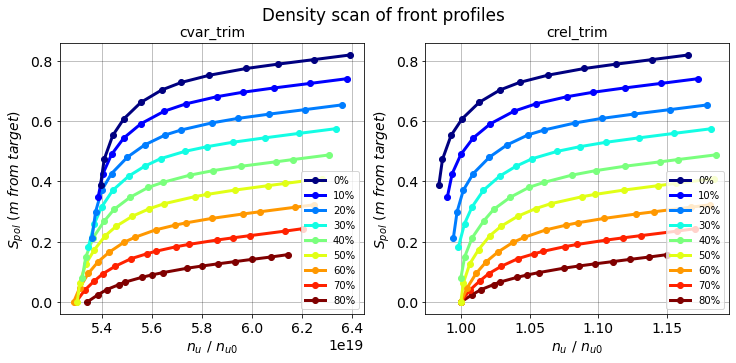

In [209]:
labels = {"cvar_trim":"Upstream density", "crel_trim":"$n_{u}\ /\ n_{u0}$"}
colors = make_colors(len(list_cuts), plt.get_cmap("jet"))

fig, axes = plt.subplots(1,2, figsize = (12,5))

for k, basis in enumerate(["cvar_trim", "crel_trim"]):
    fig.suptitle("Density scan of front profiles")

    ax = axes[k] 
    for i, cut in enumerate(list_cuts):
        ax.plot(result_stats[basis][i], result_stats["SpolPlot"][i],  marker = "o", 
                label = "{:.0%}".format(cut), markersize = 6, 
                linewidth = 3, color = colors[i],
                zorder = len(list_cuts)-i)
        ax.set_title(basis)
        if "crel" in basis:
            ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
        # ax.set_xlim(0.975, 1.05)
        # ax.set_ylim(0,5)

    for ax in axes:
        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel(labels[basis])
        ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
        ax.legend(fontsize = 10)
    

Text(439.98636363636354, 0.5, 'Fraction of unstable region ')

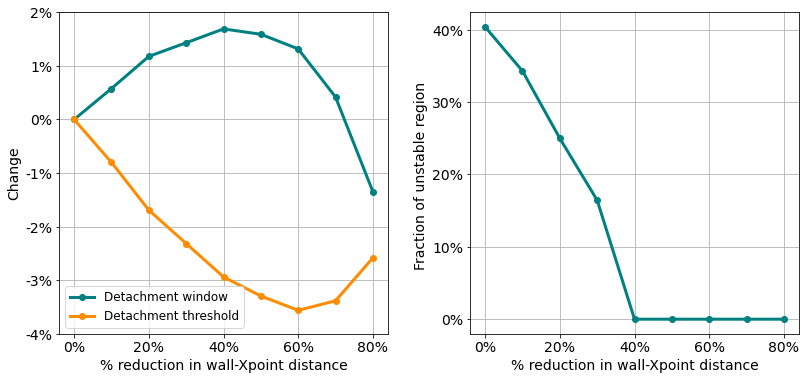

In [61]:
fig, axes = plt.subplots(1,2, figsize = (12,6))
fig.tight_layout(pad=3)

colors = mike_cmap(2)

ax = axes[0]
ax.plot(stats[side]["polreduction"], result_stats["rel_windows"]-1, marker ="o", linewidth = 3, color = colors[0], label = "Detachment window")
ax.plot(stats[side]["polreduction"], result_stats["rel_thresholds"]-1, marker = "o", linewidth = 3, color = colors[1], label = "Detachment threshold")
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_locator(MultipleLocator(0.01))

ax.set_ylim(-0.04, 0.02)

ax.legend(loc = "lower left", fontsize = 12)
ax.set_xlabel("% reduction in wall-Xpoint distance")
ax.set_ylabel("Change")

ax = axes[1]
ax.plot(list_cuts,result_stats["unstable_fracs"], marker ="o", linewidth = 3, color = colors[0])
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.set_title("Unstable region")
ax.set_xlabel("% reduction in wall-Xpoint distance")
ax.set_ylabel("% of poloidal length")

# Multi variable study

In [45]:
mvar_study = dict()

for side in ["iu"]:
    mvar_study[side] = dict()
    print("Solving side", side)
    
    for control_variable in ["impurity_frac", "density", "power"]:
        mvar_study[side][control_variable] = dict()
        print(f"Solving {control_variable}...")
    
        for cut in data_cuts[side].keys():
            print("Solving reduction", cut)
            out = []
            results = dict()

            for param in ["window", "threshold", "window_ratio"]:
                results[param] = []

            d = copy.deepcopy(data_cuts[side][cut])
            i = 0

            constants = constants_default.copy()
            radios = radios_default.copy()

            SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
            indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]

            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
            constants["Lfunc"] = LfuncKallenbachAr
            constants["cz0"] = 0.02
            constants["qpllu0"] = 0.8e9 * 220/100

            out = (LRBv21(constants,radios,d["S"],d["Spol"],indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 1, verbosity = 0,
                                                control_variable = control_variable))

            mvar_study[side][control_variable][cut] = out

Solving side iu
Solving impurity_frac...
Solving reduction 0.0
Solving...0...100...184...254...311...359...398...429...452...470...484...496...507...518...529...Complete in 25.9 seconds
Solving reduction 0.1
Solving...0...88...163...225...277...319...355...383...403...419...433...444...455...465...476...Complete in 28.0 seconds
Solving reduction 0.2
Solving...0...77...142...197...242...281...312...337...355...369...382...393...403...413...423...Complete in 26.7 seconds
Solving reduction 0.3
Solving...0...66...122...169...208...242...269...290...306...319...331...341...351...360...370...Complete in 27.0 seconds
Solving reduction 0.4
Solving...0...55...102...141...175...204...227...244...258...270...280...290...299...308...317...Complete in 25.7 seconds
Solving reduction 0.5
Solving...0...44...82...114...143...166...184...198...210...221...230...239...247...255...264...Complete in 23.8 seconds
Solving reduction 0.6
Solving...0...34...63...89...110...127...141...153...163...172...180...18

In [ ]:
labels = {"cvar_trim":"Upstream density", "crel_trim":"$n_{u}\ /\ n_{u0}$"}
# mvar_study[side][control_variable][cut] = out

colors = make_colors(len(list_cuts), plt.get_cmap("jet"))
cvar = "impurity_frac"
fig, axes = plt.subplots(1,2, figsize = (12,5))
basis = "crel_trim"

for k, basis in enumerate(["cvar_trim", "crel_trim"]):

    fig.suptitle("Density scan of front profiles")

    ax = axes[k] 
    for i, cut in enumerate(list_cuts):
        ax.plot(mvar_study[side][cvar][cut][basis], mvar_study[side][cvar][cut]["SpolPlot"],  marker = "o", 
                label = "{:.0%}".format(cut), markersize = 6, 
                linewidth = 3, color = colors[i],
                zorder = len(list_cuts)-i)
        ax.set_title(basis)
        if "crel" in basis:
            ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
        # ax.set_xlim(0.975, 1.05)
        # ax.set_ylim(0,5)

    for ax in axes:
        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel(labels[basis])
        ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
        ax.legend(fontsize = 10)
    

In [ ]:
summary = defaultdict(dict)
side = "iu"
control_variables = ["impurity_frac", "density", "power"]

for cvar in control_variables:
    summary[cvar]["window_ratio"] = []
    summary[cvar]["threshold"] = []
    summary[cvar]["spol_onset"] = []
    
    for cut in list_cuts:
        summary[cvar]["window_ratio"].append(mvar_study[side][cvar][cut]["window_ratio"])
        summary[cvar]["threshold"].append(mvar_study[side][cvar][cut]["threshold"])
        summary[cvar]["spol_onset"].append(mvar_study[side][cvar][cut]["spol_onset"])
    
summary["power"]["window_ratio"] = 1/np.array(summary["power"]["window_ratio"])

for cvar in control_variables:
    keys = list(summary[cvar].keys())
    for key in keys:
        summary[cvar][key] = np.array(summary[cvar][key])
        summary[cvar][f"{key}_rel"] = summary[cvar][key] / summary[cvar][key][0]
        
summary["power"]["threshold_rel"] = 1/summary["power"]["threshold_rel"]

In [ ]:
# mvar_study[side][control_variable][cut] = results.copy()

fig, axes = plt.subplots(1,3, figsize = (15,5))
fig.tight_layout(pad=3)
labels = {"density":"$n_{u}$", "impurity_frac":"$f_{z}$", "power":"$q_\parallel$"}

colors = mike_cmap(3)

ax = axes[0]
for i, cvar in enumerate(control_variables):
    ax.plot(stats[side]["polreduction"], summary[cvar]["window_ratio_rel"]-1, label = labels[cvar], color = colors[i], marker = "o")
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_locator(MultipleLocator(0.01))
ax.set_ylabel("Change")
ax.set_title("Detachment window")
ax.legend(loc = "lower left", fontsize = 12)

ax = axes[1]
for i, cvar in enumerate(control_variables):
    ax.plot(stats[side]["polreduction"], summary[cvar]["threshold_rel"]-1, label = labels[cvar], color = colors[i], marker = "o")

ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_locator(MultipleLocator(0.01))
ax.set_xlabel("% reduction in wall-Xpoint distance")
ax.set_title("Threshold")
ax.set_ylabel("Change")

ax = axes[2]
for i, cvar in enumerate(control_variables):
    ax.plot(stats[side]["polreduction"], summary[cvar]["spol_onset"], label = labels[cvar], marker ="o", linewidth = 3, color = colors[i])
ax.set_title("Unstable region")
ax.set_ylabel("% of poloidal length")
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))

for ax in axes:
    ax.legend()
    ax.set_xlabel("% Reduction in $L_{X,pol}$")
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))

# 10% power

In [50]:
mvar_study_loq = dict()

for side in ["iu"]:
    mvar_study_loq[side] = dict()
    print("Solving side", side)
    
    for control_variable in ["impurity_frac", "density", "power"]:
        mvar_study_loq[side][control_variable] = dict()
        print(f"Solving {control_variable}...")
    
        for cut in data_cuts[side].keys():
            print("Solving reduction", cut)
            out = []
            results = dict()

            for param in ["window", "threshold", "window_ratio"]:
                results[param] = []

            d = copy.deepcopy(data_cuts[side][cut])
            i = 0

            constants = constants_default.copy()
            radios = radios_default.copy()

            SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
            indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]

            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
            constants["Lfunc"] = LfuncKallenbachAr
            constants["cz0"] = 0.02
            constants["qpllu0"] = 1e8 * (220/100) # Modify for SPR38

            out = (LRBv21(constants,radios,d["S"],d["Spol"],indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 1, verbosity = 0,
                                                control_variable = control_variable))

            mvar_study_loq[side][control_variable][cut] = out

Solving side iu
Solving impurity_frac...
Solving reduction 0.0
Solving...0...100...184...254...311...359...398...429...452...470...484...496...507...518...529...Complete in 19.8 seconds
Solving reduction 0.1
Solving...0...88...163...225...277...319...355...383...403...419...433...444...455...465...476...Complete in 19.7 seconds
Solving reduction 0.2
Solving...0...77...142...197...242...281...312...337...355...369...382...393...403...413...423...Complete in 20.4 seconds
Solving reduction 0.3
Solving...0...66...122...169...208...242...269...290...306...319...331...341...351...360...370...Complete in 20.6 seconds
Solving reduction 0.4
Solving...0...55...102...141...175...204...227...244...258...270...280...290...299...308...317...Complete in 20.0 seconds
Solving reduction 0.5
Solving...0...44...82...114...143...166...184...198...210...221...230...239...247...255...264...Complete in 19.6 seconds
Solving reduction 0.6
Solving...0...34...63...89...110...127...141...153...163...172...180...18

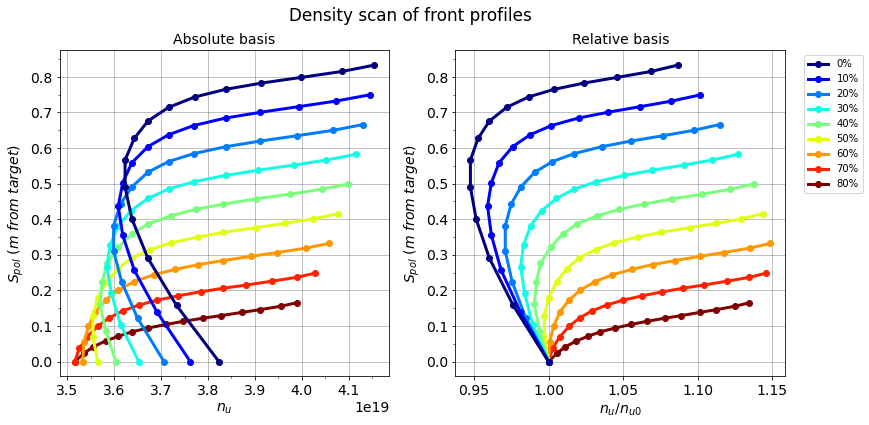

In [94]:
labels = {"cvar":"Upstream density", "crel":"$n_{u}\ /\ n_{u0}$"}
# mvar_study[side][control_variable][cut] = out

colors = make_colors(len(list_cuts), plt.get_cmap("jet"))
cvar = "density"
fig, axes = plt.subplots(1,2, figsize = (13,6))
basis = "crel_trim"

for k, basis in enumerate(["cvar", "crel"]):

    fig.suptitle("Density scan of front profiles")

    ax = axes[k] 
    for i, cut in enumerate(list_cuts):
        ax.plot(mvar_study_loq[side][cvar][cut][basis], mvar_study_loq[side][cvar][cut]["SpolPlot"],  marker = "o", 
                label = "{:.0%}".format(cut), markersize = 6, 
                linewidth = 3, color = colors[i],
                zorder = len(list_cuts)-i)
        
        if "crel" in basis:
            ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
            
    for ax in axes:
        ax.grid(color ="black", alpha = 0.3)
        
        ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
        ax.yaxis.set_major_locator(MultipleLocator(0.1))
        ax.yaxis.set_minor_locator(MultipleLocator(0.05))
        
axes[0].xaxis.set_major_locator(MultipleLocator(0.1e19))
axes[1].xaxis.set_major_locator(MultipleLocator(0.05))
axes[0].xaxis.set_minor_locator(MultipleLocator(0.05e19))
axes[0].set_title("Absolute basis")
axes[1].set_title("Relative basis")
axes[0].set_xlabel("$n_u$")
axes[1].set_xlabel("$n_{u}/n_{u0}$")
ax.legend(fontsize = 10, bbox_to_anchor=(1.25,1))
    

In [52]:
summary = defaultdict(dict)
side = "iu"
control_variables = ["impurity_frac", "density", "power"]

for cvar in control_variables:
    summary[cvar]["window_ratio"] = []
    summary[cvar]["threshold"] = []
    summary[cvar]["spol_onset"] = []
    
    for cut in list_cuts:
        summary[cvar]["window_ratio"].append(mvar_study_loq[side][cvar][cut]["window_ratio"])
        summary[cvar]["threshold"].append(mvar_study_loq[side][cvar][cut]["threshold"])
        summary[cvar]["spol_onset"].append(mvar_study_loq[side][cvar][cut]["spol_onset"])
    
summary["power"]["window_ratio"] = 1/np.array(summary["power"]["window_ratio"])

for cvar in control_variables:
    keys = list(summary[cvar].keys())
    for key in keys:
        summary[cvar][key] = np.array(summary[cvar][key])
        summary[cvar][f"{key}_rel"] = summary[cvar][key] / summary[cvar][key][0]
        
summary["power"]["threshold_rel"] = 1/summary["power"]["threshold_rel"]

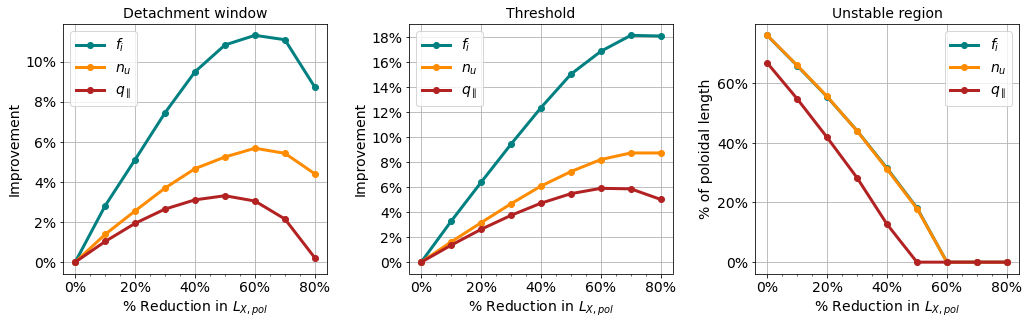

In [73]:
# mvar_study[side][control_variable][cut] = results.copy()

fig, axes = plt.subplots(1,3, figsize = (15,5))
fig.tight_layout(pad=3)
labels = {"density":"$n_{u}$", "impurity_frac":"$f_{i}$", "power":"$q_\parallel$"}

colors = mike_cmap(3)

ax = axes[0]
for i, cvar in enumerate(control_variables):
    ax.plot(stats[side]["polreduction"], summary[cvar]["window_ratio_rel"]-1, label = labels[cvar], color = colors[i], marker = "o")
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_locator(MultipleLocator(0.02))
ax.set_ylabel("Improvement")
ax.set_title("Detachment window")
ax.legend(loc = "lower left", fontsize = 12)

ax = axes[1]
for i, cvar in enumerate(control_variables):
    ax.plot(stats[side]["polreduction"], 1/summary[cvar]["threshold_rel"]-1, label = labels[cvar], color = colors[i], marker = "o")

ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_locator(MultipleLocator(0.02))
ax.set_xlabel("% reduction in wall-Xpoint distance")
ax.set_title("Threshold")
ax.set_ylabel("Improvement")

ax = axes[2]
for i, cvar in enumerate(control_variables):
    ax.plot(stats[side]["polreduction"], summary[cvar]["spol_onset"], label = labels[cvar], marker ="o", linewidth = 3, color = colors[i])
ax.set_title("Unstable region")
ax.set_ylabel("% of poloidal length")
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))

for ax in axes:
    ax.legend()
    ax.set_xlabel("% Reduction in $L_{X,pol}$")
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))

# Scalings

In [31]:
s.keys()

dict_keys(['Xpoint', 'Lx', 'Lpolx', 'Bx', 'Bt', 'BxBt', 'polreduction', 'reduction', 'BxBt_reduction'])

In [40]:
side = "iu"
s = stats[side]

s["Bavg"] = []

for cut in list_cuts:

    d = data_cuts[side][cut]
    s["Bavg"].append(np.mean(d["Btot"][:d["Xpoint"]]))
    
s["Bavg_change"] = s["Bavg"] / s["Bavg"][0]
print(s["Bavg_change"])

[1.         0.98123191 0.96331778 0.94622462 0.92989292 0.91429572
 0.89936552 0.88513651 0.87145563]


In [81]:
s["BxBt_change"] = s["BxBt"] / s["BxBt"][0]

Lx_factor = (1-s["reduction"])
BxBt_factor = s["BxBt_change"]
Bavg_factor = s["Bavg_change"] 

threshold_change = Lx_factor ** (2/7) * BxBt_factor **(1) *Bavg_factor**(2/7)-1
window_change = Lx_factor ** (3/8) * BxBt_factor **(1) *Bavg_factor**(2/7)-1


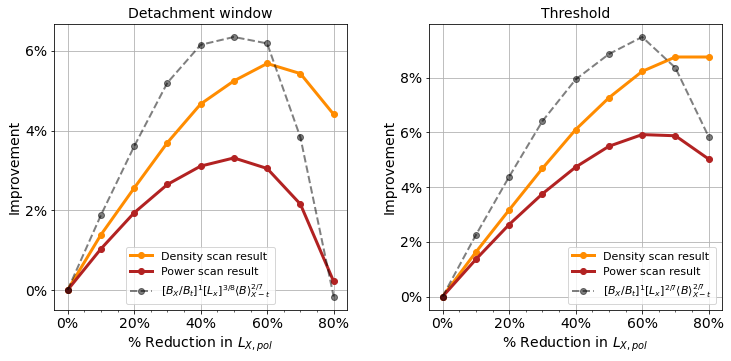

In [101]:
# mvar_study[side][control_variable][cut] = results.copy()

fig, axes = plt.subplots(1,2, figsize = (11,5.5))
fig.tight_layout(pad=3)
labels = {"density":"$n_{u}$", "impurity_frac":"$f_{i}$", "power":"$q_\parallel$"}

colors = mike_cmap(3)
cvar = "density"
ax = axes[0]

ax.plot(stats[side]["polreduction"], summary[cvar]["window_ratio_rel"]-1, label = "Density scan result", color = "darkorange", marker = "o")
ax.plot(stats[side]["polreduction"], summary["power"]["window_ratio_rel"]-1, label = "Power scan result", color = "firebrick", marker = "o")
ax.plot(stats[side]["polreduction"], window_change, linewidth = 2, color = "black", linestyle = "dashed", alpha = 0.5, marker = "o", label = r"$[B_X/B_t]^{1}[L_x]^{3/8}{\langle}B{\rangle}^{2/7}_{X-t}$")

ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_locator(MultipleLocator(0.02))
ax.set_ylabel("Improvement")
ax.set_title("Detachment window")
ax.legend(loc = "lower left", fontsize = 12)

ax = axes[1]

ax.plot(stats[side]["polreduction"], 1/summary[cvar]["threshold_rel"]-1, label = "Density scan result", color = "darkorange", marker = "o")
ax.plot(stats[side]["polreduction"], 1/summary["power"]["threshold_rel"]-1, label = "Power scan result", color = "firebrick", marker = "o")
ax.plot(stats[side]["polreduction"], threshold_change, linewidth = 2, color = "black", linestyle = "dashed", alpha = 0.5, marker = "o", label = r"$[B_X/B_t]^{1}[L_x]^{2/7}{\langle}B{\rangle}^{2/7}_{X-t}$")

ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_locator(MultipleLocator(0.02))
ax.set_xlabel("% reduction in wall-Xpoint distance")
ax.set_title("Threshold")
ax.set_ylabel("Improvement")


for ax in axes:
    ax.legend(fontsize = 11)
    ax.set_xlabel("% Reduction in $L_{X,pol}$")
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))

# 10% power hires

In [6]:
list_cuts = np.round(np.arange(0, 0.9, 0.1), 2)
# list_cuts = [0.1, 0.5, 0.9, 1.0]

data_cuts2 = dict()
design = "SPR38"
stats2 = dict()

for side in ["iu", "ou"]:
    data_cuts2[side] = dict()
    stats2[side] = defaultdict(list)
    
    for cut in list_cuts:
        data_cuts2[side][cut] = cut_wall(eqb100k[side][design], cut)
        d = data_cuts2[side][cut]
        
        stats2[side]["Xpoint"].append(d["Xpoint"])
        stats2[side]["Lx"].append(d["S"][d["Xpoint"]])
        stats2[side]["Lpolx"].append(d["Spol"][d["Xpoint"]])
        stats2[side]["Bx"].append(d["Btot"][d["Xpoint"]])
        stats2[side]["Bt"].append(d["Btot"][0])
        stats2[side]["BxBt"].append(d["Btot"][d["Xpoint"]] / d["Btot"][0])
        stats2[side]["polreduction"].append(cut) # reduction factor
        
    stats2[side]["reduction"] = np.round(1 - stats2["iu"]["Lx"] / stats2["iu"]["Lx"][0], 2)

print("Cuts prepared: ",list_cuts)

Cuts prepared:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]


In [18]:
mvar_study_loq_100k = dict()

for side in ["iu"]:
    mvar_study_loq_100k[side] = dict()
    print("Solving side", side)
    
    for control_variable in ["impurity_frac", "density", "power"]:
        mvar_study_loq_100k[side][control_variable] = dict()
        print(f"Solving {control_variable}...")
    
        for cut in data_cuts2[side].keys():
            print("Solving reduction", cut)
            out = []
            results = dict()

            for param in ["window", "threshold", "window_ratio"]:
                results[param] = []

            d = copy.deepcopy(data_cuts2[side][cut])
            i = 0

            constants = constants_default.copy()
            radios = radios_default.copy()

            SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 30)
            indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]

            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
            constants["Lfunc"] = LfuncKallenbachAr
            constants["cz0"] = 0.02
            constants["qpllu0"] = 1e8 * (220/100) # Modify for SPR38

            out = (LRBv21(constants,radios,d["S"],d["Spol"],indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = control_variable))

            mvar_study_loq_100k[side][control_variable][cut] = out

Solving side iu
Solving impurity_frac...
Solving reduction 0.0
Solving...0...1018...1951...2804...3587...4303...4958...5557...6104...6600...7050...7461...7838...8177...8477...8736...8956...9147...9315...9467...9604...9731...9850...9962...10070...10175...10279...10384...10491...10602...Complete in 216.0 seconds
Solving reduction 0.1
Solving...0...897...1721...2478...3174...3812...4398...4935...5424...5869...6276...6649...6991...7296...7563...7791...7989...8163...8318...8458...8587...8707...8820...8927...9030...9131...9231...9332...9436...9543...Complete in 198.6 seconds
Solving reduction 0.2
Solving...0...779...1497...2159...2769...3330...3846...4319...4750...5146...5510...5845...6148...6416...6648...6848...7024...7181...7323...7453...7573...7685...7791...7893...7991...8087...8183...8281...8380...8483...Complete in 222.2 seconds
Solving reduction 0.3
Solving...0...665...1279...1847...2373...2857...3303...3711...4086...4434...4756...5048...5308...5537...5735...5909...6064...6205...6333..

In [19]:
file_write(mvar_study_loq_100k, "10-mvar_study_loq_100k.pkl")
print("Complete")

In [ ]:
mvar_study_loq_100k = file_read("10-mvar_study_loq_100k.pkl")
print("Complete)

In [13]:
summary = defaultdict(dict)
side = "iu"
control_variables = ["impurity_frac", "density", "power"]

for cvar in control_variables:
    summary[cvar]["window_ratio"] = []
    summary[cvar]["threshold"] = []
    summary[cvar]["spol_onset"] = []
    
    for cut in list_cuts:
        summary[cvar]["window_ratio"].append(mvar_study_loq_100k[side][cvar][cut]["window_ratio"])
        summary[cvar]["threshold"].append(mvar_study_loq_100k[side][cvar][cut]["threshold"])
        summary[cvar]["spol_onset"].append(mvar_study_loq_100k[side][cvar][cut]["spol_onset"])
        print(".", end = "")
    
summary["power"]["window_ratio"] = 1/np.array(summary["power"]["window_ratio"])
for cvar in control_variables:
    keys = list(summary[cvar].keys())
    for key in keys:
        summary[cvar][key] = np.array(summary[cvar][key])
        summary[cvar][f"{key}_rel"] = summary[cvar][key] / summary[cvar][key][0]
        print(".", end = "")
        
summary["power"]["threshold_rel"] = 1/summary["power"]["threshold_rel"]
print("Complete")

....................................Complete


In [12]:
summary["density"]["threshold"]

NameError: name 'summary' is not defined

In [ ]:
# mvar_study[side][control_variable][cut] = results.copy()

fig, axes = plt.subplots(1,3, figsize = (15,5))
fig.tight_layout(pad=3)
labels = {"density":"$n_{u}$", "impurity_frac":"$f_{i}$", "power":"$q_\parallel$"}

colors = mike_cmap(3)

ax = axes[0]
for i, cvar in enumerate(control_variables):
    ax.plot(stats[side]["polreduction"], summary[cvar]["window_ratio_rel"]-1, label = labels[cvar], color = colors[i], marker = "o")
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_locator(MultipleLocator(0.02))
ax.set_ylabel("Change")
ax.set_title("Detachment window")
ax.legend(loc = "lower left", fontsize = 12)

ax = axes[1]
for i, cvar in enumerate(control_variables):
    ax.plot(stats[side]["polreduction"], summary[cvar]["threshold_rel"]-1, label = labels[cvar], color = colors[i], marker = "o")

ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_locator(MultipleLocator(0.02))
ax.set_xlabel("% reduction in wall-Xpoint distance")
ax.set_title("Threshold")
ax.set_ylabel("Change")

ax = axes[2]
for i, cvar in enumerate(control_variables):
    ax.plot(stats[side]["polreduction"], summary[cvar]["spol_onset"], label = labels[cvar], marker ="o", linewidth = 3, color = colors[i])
ax.set_title("Unstable region")
ax.set_ylabel("% of poloidal length")
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))

for ax in axes:
    ax.legend()
    ax.set_xlabel("% Reduction in $L_{X,pol}$")
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))

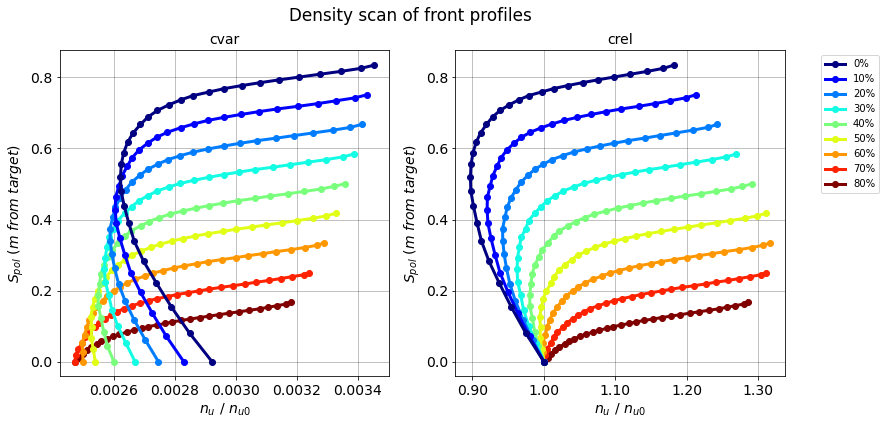

In [20]:
labels = {"cvar_trim":"$n_u$", "cvar":"$n_u$", "crel_trim":"$n_{u}\ /\ n_{u0}$", "crel":"$n_{u}\ /\ n_{u0}$"}
# mvar_study[side][control_variable][cut] = out

colors = make_colors(len(list_cuts), plt.get_cmap("jet"))
cvar = "impurity_frac"
fig, axes = plt.subplots(1,2, figsize = (13,6))
basis = "cvar"

for k, basis in enumerate(["cvar", "crel"]):

    fig.suptitle("Density scan of front profiles")

    ax = axes[k] 
    for i, cut in enumerate(list_cuts):
        ax.plot(mvar_study_loq_100k[side][cvar][cut][basis], mvar_study_loq_100k[side][cvar][cut]["SpolPlot"],  marker = "o", 
                label = "{:.0%}".format(cut), markersize = 6, 
                linewidth = 3, color = colors[i],
                zorder = len(list_cuts)-i)
        ax.set_title(basis)
        if "crel" in basis:
            ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
        # ax.set_xlim(0.975, 1.05)
        # ax.set_ylim(0,5)

    for ax in axes:
        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel(labels[basis])
        ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
        
ax.legend(fontsize = 10, bbox_to_anchor=(1.3,1))
    